In [1]:
!pip install pyspark
!pip install plotly
!pip install pandas
!pip install datetime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.8/259.8 kB 6.4 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


===== MrBeast YouTube Video Analysis =====

1. BEST TIMES TO POST

Best Days to Post:
    day_name     avg_views  avg_engagement
0   Saturday  3.651141e+06        0.029885
1     Sunday  1.801822e+06        0.022510
2  Wednesday  1.065962e+06        0.019132
3     Monday  1.639484e+05        0.019451
4   Thursday  9.263056e+04        0.019801
5     Friday  6.927157e+04        0.022537
6    Tuesday  5.669429e+04        0.018461

Best Hours to Post:
    publish_hour     avg_views  avg_engagement
0             21  3.700277e+06        0.023846
1              2  2.731879e+06        0.029114
2             23  1.864202e+06        0.019058
3             20  1.930392e+05        0.016954
4             16  1.704190e+05        0.020208
5              1  1.120464e+05        0.022933
6             22  9.293617e+04        0.021084
7             19  7.429450e+04        0.025211
8              3  6.449100e+04        0.017348
9             15  6.176300e+04        0.027686
10             0  5.726843e+04  

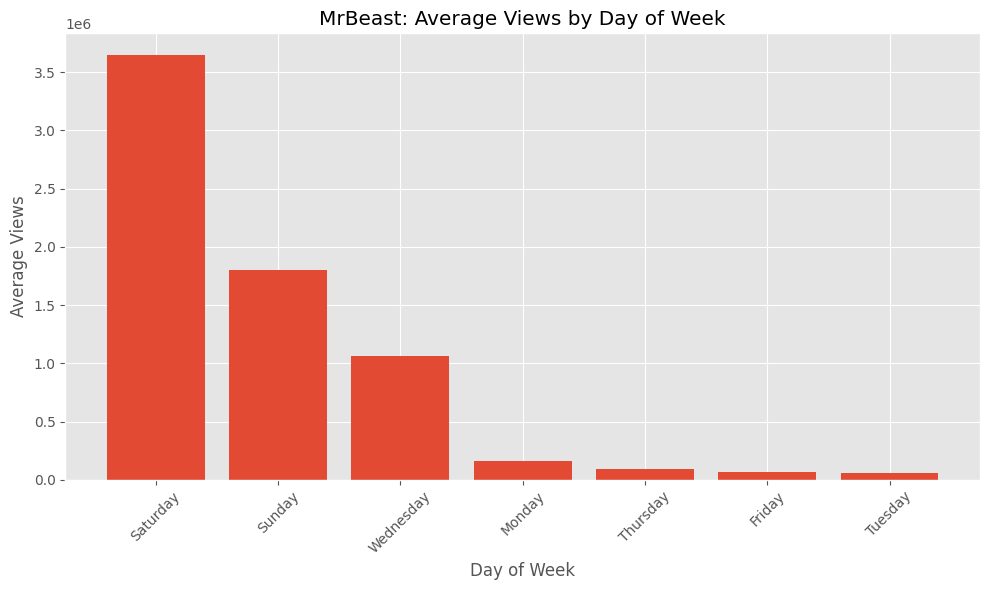

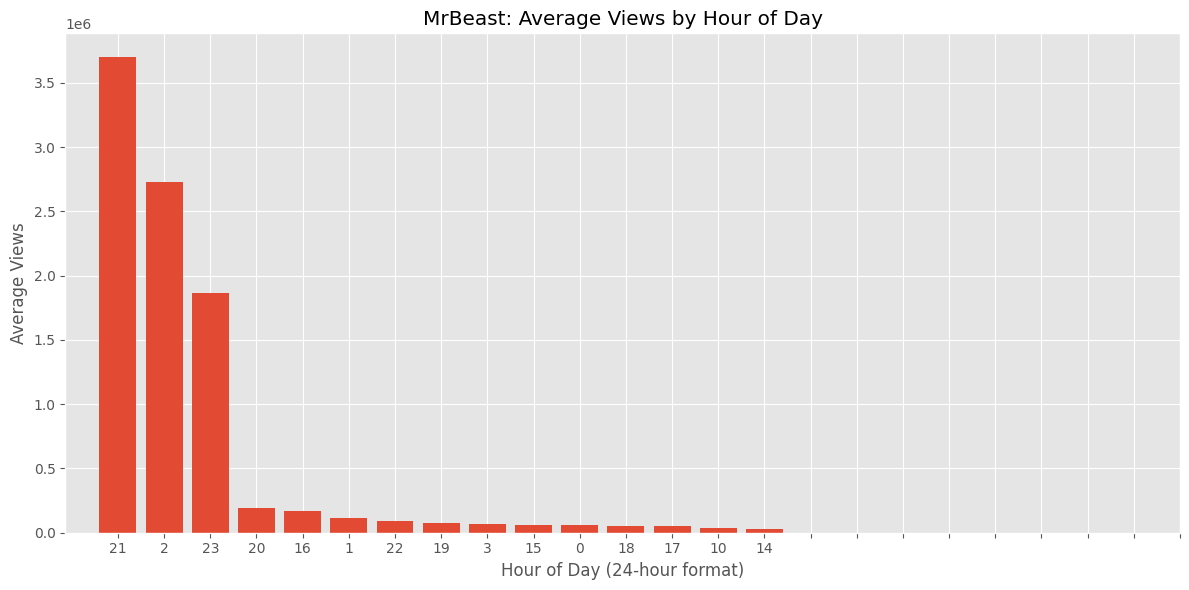

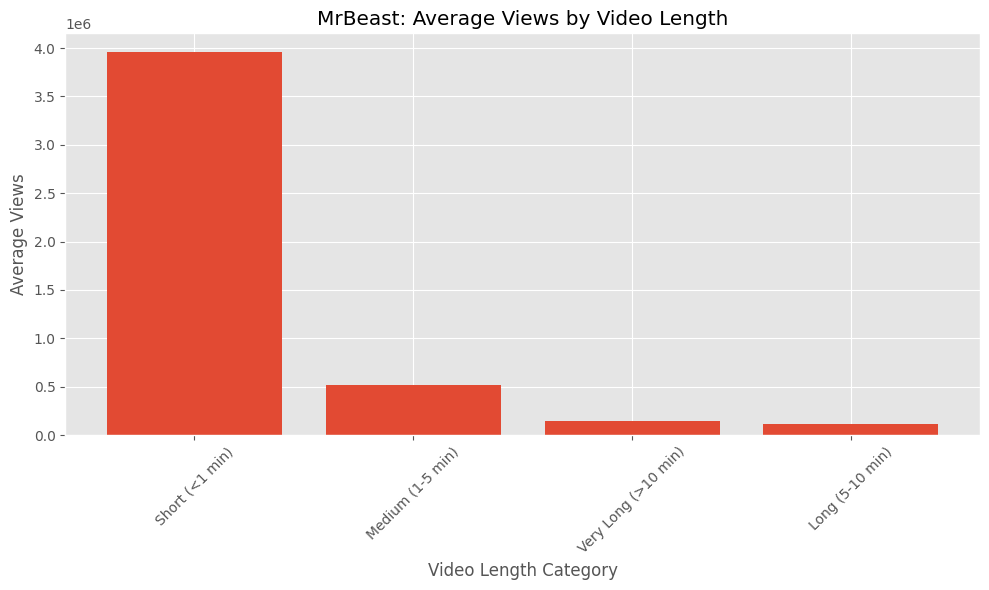

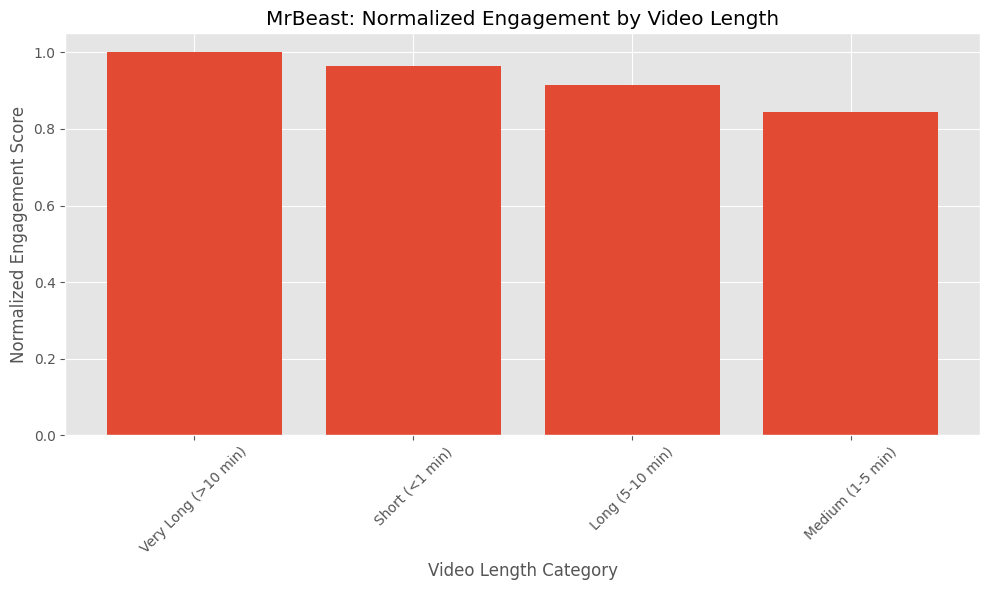


        MRBEAST YOUTUBE VIDEO ANALYSIS RECOMMENDATIONS

        Based on analysis of MrBeast's video performance:

        1. POSTING SCHEDULE:
           - Best day to post: Saturday
           - Best hours to post: 21:00, 2:00, 23:00

        2. VIDEO CONTENT:
           - Most successful video length: Short (<1 min)
           - Optimal title length: 38 characters
           - 1.69% of titles include dollar amounts ($)
           - 45.76% of titles include numbers

        3. ENGAGEMENT:
           - Average like-to-view ratio: 4.06%
           - Average comment-to-view ratio: 0.81%

        KEY OBSERVATIONS:
        - MrBeast's most successful videos tend to be Short (<1 min)
        - Titles often include monetary amounts and specific numbers
        - Engagement is highest for videos posted on Saturday around 21:00
        


In [5]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, date_format, to_timestamp, datediff, hour, dayofweek,
    regexp_replace, expr, concat_ws, when, avg, count, desc,
    lit, round, sum, udf, length, split, size, regexp_extract, isnull
)
from pyspark.sql.types import DoubleType, IntegerType, TimestampType
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("MrBeast YouTube Video Analysis") \
    .getOrCreate()

# Load the dataset
df = spark.read.csv("/content/drive/MyDrive/VideoDetails.csv", header=True, inferSchema=True)

# Step 1: Data Cleaning for MrBeast dataset
def clean_mrbeast_data(df):
    # Convert publishedAt to timestamp with proper null handling
    df = df.withColumn("publishedAt",
                      when(col("publishedAt").isNotNull(),
                           to_timestamp(col("publishedAt"), "yyyy-MM-dd HH:mm:ss+00:00")))

    # Filter out rows with null timestamps
    df = df.filter(col("publishedAt").isNotNull())

    # Convert duration from PT format to seconds
    df = df.withColumn("durationSecs", col("durationSecs").cast(IntegerType()))

    # Handle viewCount, likeCount, commentCount - some might be null
    numerical_cols = ["viewCount", "likeCount", "commentCount"]
    for column in numerical_cols:
        df = df.withColumn(column, col(column).cast(IntegerType()))
        df = df.withColumn(column, when(col(column).isNull(), 0).otherwise(col(column)))

    # Calculate engagement score with null handling
    df = df.withColumn("engagement_score",
                      (col("likeCount") * 0.4 + col("commentCount") * 0.6) /
                      when(col("viewCount") > 0, col("viewCount")).otherwise(1))

    # Extract day of week and hour from publishedAt with null checks
    df = df.withColumn("publish_day", dayofweek(col("publishedAt")))
    df = df.withColumn("publish_hour", hour(col("publishedAt")))

    # Process tags - count them
    df = df.withColumn("tagCount",
                      when(col("tags").isNull() | (col("tags") == ""), 0)
                      .otherwise(size(split(col("tags"), "\\|"))))

    # Extract video length categories
    df = df.withColumn("video_length_category",
                      when(col("durationSecs") < 60, "Short (<1 min)")
                      .when(col("durationSecs") < 300, "Medium (1-5 min)")
                      .when(col("durationSecs") < 600, "Long (5-10 min)")
                      .otherwise("Very Long (>10 min)"))

    return df

# Clean the dataset
clean_df = clean_mrbeast_data(df)

# Step 2: Analysis Functions

def analyze_posting_times(df):
    # Filter out any null values in time-related columns
    df = df.filter(col("publish_day").isNotNull() & col("publish_hour").isNotNull())

    # Best days of the week
    day_analysis = df.groupBy("publish_day") \
        .agg(
            count("*").alias("video_count"),
            avg("viewCount").alias("avg_views"),
            avg("engagement_score").alias("avg_engagement"),
            avg("durationSecs").alias("avg_duration")
        ) \
        .orderBy(desc("avg_views"))

    # Best hours of the day - filter out any potential null hours
    hour_analysis = df.filter(col("publish_hour").isNotNull()) \
        .groupBy("publish_hour") \
        .agg(
            count("*").alias("video_count"),
            avg("viewCount").alias("avg_views"),
            avg("engagement_score").alias("avg_engagement"),
            avg("durationSecs").alias("avg_duration")
        ) \
        .orderBy(desc("avg_views"))

    return {
        "day_analysis": day_analysis,
        "hour_analysis": hour_analysis
    }

def analyze_video_length_impact(df):
    # Impact of video length on performance
    length_analysis = df.groupBy("video_length_category") \
        .agg(
            count("*").alias("video_count"),
            avg("viewCount").alias("avg_views"),
            avg("engagement_score").alias("avg_engagement"),
            avg("likeCount").alias("avg_likes"),
            avg("commentCount").alias("avg_comments")
        ) \
        .orderBy(desc("avg_views"))

    return length_analysis

def analyze_title_impact(df):
    # Title length analysis
    df = df.withColumn("title_length", length(col("title")))

    title_analysis = df.groupBy() \
        .agg(
            avg("title_length").alias("avg_title_length"),
            expr("percentile(title_length, 0.5)").alias("median_title_length"),
            expr("percentile(title_length, 0.25)").alias("percentile_25_title_length"),
            expr("percentile(title_length, 0.75)").alias("percentile_75_title_length")
        )

    # Title keywords analysis
    df = df.withColumn("contains_dollar", col("title").contains("$"))
    df = df.withColumn("contains_number", col("title").rlike("\d"))

    keyword_analysis = df.groupBy() \
        .agg(
            (sum(when(col("contains_dollar"), 1).otherwise(0)) / count("*") * 100).alias("percent_with_dollar"),
            (sum(when(col("contains_number"), 1).otherwise(0)) / count("*") * 100).alias("percent_with_number")
        )

    return {
        "title_length_analysis": title_analysis,
        "keyword_analysis": keyword_analysis
    }

def analyze_engagement(df):
    # Like and comment ratios
    engagement_analysis = df.withColumn("like_ratio", col("likeCount") / col("viewCount")) \
        .withColumn("comment_ratio", col("commentCount") / col("viewCount")) \
        .groupBy() \
        .agg(
            avg("like_ratio").alias("avg_like_ratio"),
            avg("comment_ratio").alias("avg_comment_ratio"),
            avg("engagement_score").alias("avg_engagement_score")
        )

    # Engagement by video length
    engagement_by_length = df.groupBy("video_length_category") \
        .agg(
            avg("engagement_score").alias("avg_engagement"),
            count("*").alias("video_count")
        ) \
        .orderBy(desc("avg_engagement"))

    return {
        "overall_engagement": engagement_analysis,
        "engagement_by_length": engagement_by_length
    }

# Run all analyses
time_analysis = analyze_posting_times(clean_df)
length_analysis = analyze_video_length_impact(clean_df)
title_analysis = analyze_title_impact(clean_df)
engagement_analysis = analyze_engagement(clean_df)

# Convert to pandas for visualization
day_mapping = {1: "Sunday", 2: "Monday", 3: "Tuesday",
               4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"}

day_analysis_pd = time_analysis["day_analysis"].toPandas()
day_analysis_pd["day_name"] = day_analysis_pd["publish_day"].map(day_mapping)
day_analysis_pd = day_analysis_pd.sort_values("avg_views", ascending=False)

hour_analysis_pd = time_analysis["hour_analysis"].toPandas()
hour_analysis_pd = hour_analysis_pd.sort_values("avg_views", ascending=False)

length_analysis_pd = length_analysis.toPandas()
length_analysis_pd = length_analysis_pd.sort_values("avg_views", ascending=False)

# Print insights summary
print("===== MrBeast YouTube Video Analysis =====")
print("\n1. BEST TIMES TO POST")
print("\nBest Days to Post:")
print(day_analysis_pd[["day_name", "avg_views", "avg_engagement"]].head(7))
print("\nBest Hours to Post:")
print(hour_analysis_pd[["publish_hour", "avg_views", "avg_engagement"]])

print("\n2. VIDEO LENGTH IMPACT")
print("\nPerformance by Video Length:")
print(length_analysis_pd[["video_length_category", "avg_views", "avg_engagement"]])

print("\n3. TITLE ANALYSIS")
print("\nTitle Length Statistics:")
print(title_analysis["title_length_analysis"].toPandas())
print("\nTitle Keyword Analysis:")
print(title_analysis["keyword_analysis"].toPandas())

print("\n4. ENGAGEMENT ANALYSIS")
print("\nOverall Engagement Ratios:")
print(engagement_analysis["overall_engagement"].toPandas())
print("\nEngagement by Video Length:")
print(engagement_analysis["engagement_by_length"].toPandas())

# Generate visualizations
def create_mrbeast_visualizations():
    plt.style.use('ggplot')

    try:
        # 1. Best day to post
        if not day_analysis_pd.empty:
            plt.figure(figsize=(10, 6))
            plt.bar(day_analysis_pd["day_name"].astype(str),
                   day_analysis_pd["avg_views"].astype(float))
            plt.title("MrBeast: Average Views by Day of Week")
            plt.xlabel("Day of Week")
            plt.ylabel("Average Views")
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        # 2. Best hour to post
        if not hour_analysis_pd.empty:
            plt.figure(figsize=(12, 6))
            plt.bar(hour_analysis_pd["publish_hour"].astype(str),
                   hour_analysis_pd["avg_views"].astype(float))
            plt.title("MrBeast: Average Views by Hour of Day")
            plt.xlabel("Hour of Day (24-hour format)")
            plt.ylabel("Average Views")
            plt.xticks(range(0, 24))
            plt.tight_layout()
            plt.show()

        # 3. Video length impact
        if not length_analysis_pd.empty:
            valid_length_data = length_analysis_pd[length_analysis_pd['avg_views'] > 0]
            if not valid_length_data.empty:
                plt.figure(figsize=(10, 6))
                plt.bar(valid_length_data["video_length_category"].astype(str),
                       valid_length_data["avg_views"].astype(float))
                plt.title("MrBeast: Average Views by Video Length")
                plt.xlabel("Video Length Category")
                plt.ylabel("Average Views")
                plt.xticks(rotation=45)
                plt.tight_layout()
                plt.show()

        # 4. Engagement by video length
        if 'engagement_by_length' in engagement_analysis:
            engagement_by_length_pd = engagement_analysis["engagement_by_length"].toPandas()
            if not engagement_by_length_pd.empty:
                engagement_by_length_pd = engagement_by_length_pd[engagement_by_length_pd['avg_engagement'] > 0]
                if not engagement_by_length_pd.empty:
                    engagement_by_length_pd['normalized_engagement'] = (
                        engagement_by_length_pd['avg_engagement'] / engagement_by_length_pd['avg_engagement'].max()
                    )
                    plt.figure(figsize=(10, 6))
                    plt.bar(engagement_by_length_pd["video_length_category"].astype(str),
                           engagement_by_length_pd["normalized_engagement"].astype(float))
                    plt.title("MrBeast: Normalized Engagement by Video Length")
                    plt.xlabel("Video Length Category")
                    plt.ylabel("Normalized Engagement Score")
                    plt.xticks(rotation=45)
                    plt.tight_layout()
                    plt.show()

    except Exception as e:
        print(f"An error occurred while generating visualizations: {str(e)}")

create_mrbeast_visualizations()

# Generate recommendations - CORRECTED VERSION
def generate_mrbeast_recommendations():
    try:
        # Convert all necessary analyses to Pandas DataFrames
        day_analysis_pd = time_analysis["day_analysis"].toPandas()
        hour_analysis_pd = time_analysis["hour_analysis"].toPandas()
        length_analysis_pd = length_analysis.toPandas()
        title_length_pd = title_analysis["title_length_analysis"].toPandas()
        keyword_pd = title_analysis["keyword_analysis"].toPandas()
        engagement_pd = engagement_analysis["overall_engagement"].toPandas()

        # Get top day with validation
        day_mapping = {1: "Sunday", 2: "Monday", 3: "Tuesday",
                      4: "Wednesday", 5: "Thursday", 6: "Friday", 7: "Saturday"}

        top_day = "No data"
        if not day_analysis_pd.empty:
            day_analysis_pd["day_name"] = day_analysis_pd["publish_day"].map(day_mapping)
            top_day_row = day_analysis_pd.sort_values("avg_views", ascending=False).iloc[0]
            top_day = top_day_row["day_name"] if pd.notna(top_day_row["day_name"]) else "No data"

        # Get top hours (top 3) with validation
        top_hours = []
        if not hour_analysis_pd.empty:
            top_hours = hour_analysis_pd.sort_values("avg_views", ascending=False).iloc[0:3]["publish_hour"].tolist()
            top_hours = [h for h in top_hours if pd.notna(h)]

        # Get best performing video length with validation
        best_length = "No data"
        if not length_analysis_pd.empty:
            best_length_row = length_analysis_pd.sort_values("avg_views", ascending=False).iloc[0]
            best_length = best_length_row["video_length_category"] if pd.notna(best_length_row["video_length_category"]) else "No data"

        # Get title stats with validation
        optimal_title_length = 0
        if not title_length_pd.empty:
            optimal_title_length = int(title_length_pd.iloc[0]["median_title_length"]) if pd.notna(title_length_pd.iloc[0]["median_title_length"]) else 0

        # Get keyword stats with validation - using numpy/pandas for rounding
        percent_with_dollar = 0
        percent_with_number = 0
        if not keyword_pd.empty:
            percent_with_dollar = np.round(keyword_pd.iloc[0]["percent_with_dollar"], 2) if pd.notna(keyword_pd.iloc[0]["percent_with_dollar"]) else 0
            percent_with_number = np.round(keyword_pd.iloc[0]["percent_with_number"], 2) if pd.notna(keyword_pd.iloc[0]["percent_with_number"]) else 0

        # Get engagement stats with validation
        avg_like_ratio = 0
        avg_comment_ratio = 0
        if not engagement_pd.empty:
            avg_like_ratio = np.round(engagement_pd.iloc[0]["avg_like_ratio"] * 100, 2) if pd.notna(engagement_pd.iloc[0]["avg_like_ratio"]) else 0
            avg_comment_ratio = np.round(engagement_pd.iloc[0]["avg_comment_ratio"] * 100, 2) if pd.notna(engagement_pd.iloc[0]["avg_comment_ratio"]) else 0

        # Format hours for display
        formatted_hours = []
        for hour in top_hours:
            try:
                formatted_hours.append(f"{int(hour)}:00")
            except (ValueError, TypeError):
                continue

        if not formatted_hours:
            formatted_hours = ["No data available"]

        recommendations = f"""
        MRBEAST YOUTUBE VIDEO ANALYSIS RECOMMENDATIONS

        Based on analysis of MrBeast's video performance:

        1. POSTING SCHEDULE:
           - Best day to post: {top_day}
           - Best hours to post: {', '.join(formatted_hours)}

        2. VIDEO CONTENT:
           - Most successful video length: {best_length}
           - Optimal title length: {optimal_title_length} characters
           - {percent_with_dollar}% of titles include dollar amounts ($)
           - {percent_with_number}% of titles include numbers

        3. ENGAGEMENT:
           - Average like-to-view ratio: {avg_like_ratio}%
           - Average comment-to-view ratio: {avg_comment_ratio}%

        KEY OBSERVATIONS:
        - MrBeast's most successful videos tend to be {best_length}
        - Titles often include monetary amounts and specific numbers
        - Engagement is highest for videos posted on {top_day} around {formatted_hours[0] if formatted_hours else 'unknown time'}
        """

        print(recommendations)

        # Save recommendations to a file
        with open("mrbeast_recommendations.txt", "w") as f:
            f.write(recommendations)

    except Exception as e:
        print(f"An error occurred while generating recommendations: {str(e)}")

generate_mrbeast_recommendations()

# Stop Spark session
spark.stop()